In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The next line indicates to matplotlib to show the plots inline in the notebook
%matplotlib inline

# Programming assignment 

You have program (in couples) a series of functions in order to generate a protein translation table. A protein is created from a sequence of nucleic acids codified in the messenger RNA (mRNA). This mRNA is read by the ribosome three bases at a time (called codons) to add one amino acid to the protein. In total there are $4^3=64$ different codons that correspond to the possible combinations of three bases.  Each codon codifies a single amino acid. The mRNA has one start codon that always codifies M and an end codon that signals the end of the protein.

The objective of this assignment is to generate this translation table. To do so you will have to:

+ Read the genome of a species from a FASTA file
+ Read the annotation file for that genome to extract the location in the genome of the Coding Sequences (CDS) for each protein
+ Extract the mRNAs from the genome that codifies each protein using its location 
+ Read the proteins from a FASTA file
+ Generate the translation table using pairs of mRNA and protein


In the following you will find the template of the functions to use and some other interesting execises 

## File parsing 

Implement the function below to parse a fasta file. Find an example of a fasta format file here:
```
>NC_000907.1:1073118-1073456 Haemophilus influenzae Rd KW20 chromoso
ATGAAAACATTATTCACTTCGGTTGTATTGTGTGGTGCGCTGGTTGTTTCTTCGTCTTTTGCTGAGGAAA
AAGCGACAGANCAAACCGCTCAATCTGTTGTGACAACTCAAGCTGAAGCTCAAGTAGCACCAGCCGTAGT
GAGCGATAAATTGAATATCAACACAGCAACTGCCAGTGAAATTCAAAAATCCTTAACTGGCATTGGTGCG
AAAAAAGCGGAAGCTATTGTGCAATATCGTGAAAAACACGGTAATTTTKCTAATGCAGAACAGCTTTTAG
AAGTACAAGGAATTGGCAAAGCAACACTAGAGAAAAATCGTGATCGTATAATCTTTTAA
```



In [2]:
def readFasta(file):
    """ Reads all sequences of a FASTA file 
        returns a dictionary """  
    ret_seqs = {}
    seq = ""
    key_found = False
    with open(file, 'r') as f:
        key = ""
        for line in f:
            line = line.replace('\n', '')
            if len(line) > 0:
                if line[0] == ">":
                    if key_found:
                        ret_seqs[key] = seq
                    key_found = True
                    key = line[1:].split(" ")[0]
                    seq = ""
                elif key_found:
                    seq += line
    if key_found:
        ret_seqs[key] = seq
    return ret_seqs


### Tests

In [3]:
%%writefile test.fasta
>NC_000907.1
ATGAAAACATTATTCACTTCGGTTGTATTGTGTGGTGCGCTGGTTGTTTCTTCGTCTTTTGCTGAGGAAA
AAGCGACAGANCAAACCGCTCAATCTGTTGTGACAACTCAAGCTGAAGCTCAAGTAGCACCAGCCGTAGT
GAGCGATAAATTGAATATCAACACAGCAACTGCCAGTGAAATTCAAAAATCCTTAACTGGCATTGGTGCG
AAAAAAGCGGAAGCTATTGTGCAATATCGTGAAAAACACGGTAATTTTKCTAATGCAGAACAGCTTTTAG
AAGTACAAGGAATTGGCAAAGCAACACTAGAGAAAAATCGTGATCGTATAATCTTTTAACCCCC
>NC_000907.2
AAA
>NC_000907.3
AAACCCCC

Overwriting test.fasta


In [4]:
seqs = readFasta("test.fasta")
print(seqs)

{'NC_000907.1': 'ATGAAAACATTATTCACTTCGGTTGTATTGTGTGGTGCGCTGGTTGTTTCTTCGTCTTTTGCTGAGGAAAAAGCGACAGANCAAACCGCTCAATCTGTTGTGACAACTCAAGCTGAAGCTCAAGTAGCACCAGCCGTAGTGAGCGATAAATTGAATATCAACACAGCAACTGCCAGTGAAATTCAAAAATCCTTAACTGGCATTGGTGCGAAAAAAGCGGAAGCTATTGTGCAATATCGTGAAAAACACGGTAATTTTKCTAATGCAGAACAGCTTTTAGAAGTACAAGGAATTGGCAAAGCAACACTAGAGAAAAATCGTGATCGTATAATCTTTTAACCCCC', 'NC_000907.2': 'AAA', 'NC_000907.3': 'AAACCCCC'}


In [5]:
# Verify timings: initial problems with concatenation method that unable to process this file
timings = %timeit -o -n 1 -r 2 -q readFasta("homo_sapiens/homo_sapiens_chr21.fasta")
print(timings.all_runs)

[0.6505926449899562, 0.5848455819941591]


In [6]:
# Cell for checking if readFasta is working
seqs = readFasta("phix174/phix.fa")
#print(seqs['gi|216019|gb|J02482.1|PX1CG'])
# Check that the number of sequences is one
assert(len(seqs)==1)
# Check that the length of the sequences is correct
assert(len(seqs['gi|216019|gb|J02482.1|PX1CG'])==5386)

print("All tests Ok")

All tests Ok


## Count bases

In [1]:
def countBases(seq, bases = ['A', 'C', 'G', 'T']):
    """ Counts the number of occurrences of each base in the sequence seq
        There are two return values: the list of bases and the list of counts
    """
    counts = []
    for base in bases:
        counts.append(seq.count(base) + seq.count(base.lower()))
    return bases, counts
countBases("AADFF", [])

([], [])

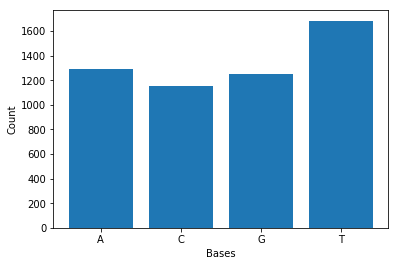

In [8]:
# Use matplotlib to show the histogram of bases for phiX174
bases, counts = countBases(seqs['gi|216019|gb|J02482.1|PX1CG']) 
plt.bar(bases, counts)
plt.xlabel('Bases')
_ = plt.ylabel('Count')

## GC Content

In [9]:
def GCContent(seq):
    """ Computes the percentage of GC content of a sequence. 
        Note that N should be ignored """
    count_GC = 0
    count_all = 0
    for base in seq:
        if base in 'GC': 
            count_GC += 1
            count_all += 1
        elif base in 'AT':
            count_all += 1
    return round(count_GC * 1.0 / count_all, 10)

### Tests

In [10]:
# Check that the GC content is correct
seqs = readFasta("phix174/phix.fa")
assert(GCContent(seqs['gi|216019|gb|J02482.1|PX1CG'])==0.4476420349)
# Check that the GC content is correct
seqs = readFasta("plamodium_falciparum/Plasmodium_falciparumchromosome_1.fa")
assert(GCContent(seqs['NC_004325.1'])==0.2054572418)

print("All tests Ok")

All tests Ok


### GC content by species

In [11]:
files = ["haemophilus_influenzae/GCF_000027305.1_ASM2730v1_genomic.fna",
         "phix174/phix.fa",
         "plamodium_falciparum/Plasmodium_falciparumchromosome_1.fa",
         "arabidopsis_thaliana/GCF_000001735.3_TAIR10_genomic.fna",
         "homo_sapiens/homo_sapiens_chr21.fasta"]

gcs = []
for file in files:
    print("Processing file:", file)
    seqs = readFasta(file)
    # Count only the first sequence
    keys = list(seqs.keys())
    gcs.append(GCContent(seqs[keys[0]])) 
    
print(gcs)

Processing file: haemophilus_influenzae/GCF_000027305.1_ASM2730v1_genomic.fna
Processing file: phix174/phix.fa
Processing file: plamodium_falciparum/Plasmodium_falciparumchromosome_1.fa
Processing file: arabidopsis_thaliana/GCF_000001735.3_TAIR10_genomic.fna
Processing file: homo_sapiens/homo_sapiens_chr21.fasta
[0.3815028554, 0.4476420349, 0.2054572418, 0.3907552942, 0.4093836458]


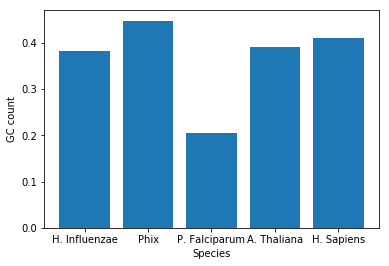

In [12]:
# Use matplotlib to show the GC content of the different species with a bar plot
plt.bar(['H. Influenzae', 'Phix', 'P. Falciparum', 'A. Thaliana', 'H. Sapiens'], gcs)
plt.xlabel('Species')
_ = plt.ylabel('GC count')

## Read Fastq

In [13]:
def readFastq(file):
    """ Read a FASTQ format file
    The read adheres specified FASTQ format in initial Sanger papers,
    that is, we expect that the sequence and scores could spread over several lines.
    It's more complicated that the simplified case more common nowadays, which considers 
    one line for scores and one line for sequence.
    Args:
        file (str): path of the file to read
    
    Returns:
        list of str: sequences
        list of str: related qualities
    """
    reads = []
    quals = []
    readsMode = False
    with open(file, 'r') as f:
        for line in f:
            line = line.replace('\n', '')
            if len(line) > 0:
                if line[0] == "+":
                    if readsMode: #this is a reads line end
                        readsMode = False
                    else: #this is a quals line
                        quals[-1] += line 
                elif line[0] == "@": 
                    #this is a quals line
                    if len(reads) > 0 and (len(quals[-1]) + len(line) <= len(reads[-1])):
                        quals[-1] += line
                    #this is a comment
                    else:  
                        reads.append("")
                        quals.append("")
                        readsMode = True
                elif readsMode:
                    reads[-1] += line
                else:
                    quals[-1] += line
 
    return reads, quals

### Test
Test with a file that spread sequence and quality scores over several lines. Also with empty lines in the middle.

In [14]:
%%writefile ugly.fastq






@SRR835775.1 1/1
TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACC
CTAACCCTAACCCTAACCGTATCCGTC
ACCCTAACCCTAAC
+
???B1ADDD8??BB+C?B+:AA883CEE8?C3@DDD3)?D2;DC?8
?=BAD=@C@(.6.6=A?=?@#######################
###########
@SRR835775.2 2/1
TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC
+
CCCFFFFFGHHGHJJJJJIJGIIJJJJJJJIJIJJJJJFJJFGIIIIH=CBFCF=CCEG)=>EHB2@@DEC>;;?=;(=?BBD?59?BA###########



@SRR835775.3 3/1
TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG
+
@@<DD?DDHHH<CBHII:CFGIGAGHIIG?CCGGE0BDHIIHIGICH8=FHGI=@EHGGGEEHH>);?CC@.;(=;?59,5<A599?CB>ABBCB><88A
@SRR835775.4 4/1
TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAAGGGTTGGGGGTTAGGGGTAGGGGTAGGGTTA
+


@CCFFDDF
H
HHDFHIJJCGGIJJHIIHJC?DHHIJ0?DGHI9BBFHICGGIGI=CDEGI=?AAEF7@?################################
@SRR835775.5 5/1
CTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTCACC
+
@<@FDFDDBBFHH@EBGGGEH@FFHE;EHIEGGBHG?)9?8BDGGBGGBCDGI=93=C6==C;CCD(?@>@#############################
@SRR835775.6 6/1
AACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTACCCCTAACCCCCAACCCTCACACCAACCCTAACCCTACCCCCAACCCCAC
+
CCCFFDFDHGHHDHHGIIIHGIJ<GBBBFBGGHDIH@B)?)0?F>DB#####################################################
@SRR835775.7 7/1
TAGGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGCTGGGTTAGGGGTAGGGTTAGGGTTAGGGTTAGGGGTAGGAGTTCGGGAGAGCACACG
+
???=DD0@3ADB<<CE;+3<;EE?1:)1?C1?3BDCB@;)99)0;@;)-(.7A'55A1?.6;(6;.5;;??#############################
@SRR835775.8 8/1
TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAACCCCAACCCTAACCCTAAACCCAAACCTAAA
+
@@@DDF?EFFHA;DDHGI<FDFGECCHF:C9DH9F3):??GHB)BFHEAHBG;C';C@EE45?#####################################


Overwriting ugly.fastq


In [15]:
r, q = readFastq('ugly.fastq')
print(len(r), len(q), len(''.join(r)),  len(''.join(q)))
# Length of all secuences and scores needs to be equal
assert len(''.join(r)) == len(''.join(q))
print(r[0])
print(q[0])
print()
print(r[3])
print(q[3])
print()
# Check the last one
print(r[-1])
print(q[-1])

8 8 800 800
TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACCCTAACCCTAACCCTAACCGTATCCGTCACCCTAACCCTAAC
???B1ADDD8??BB+C?B+:AA883CEE8?C3@DDD3)?D2;DC?8?=BAD=@C@(.6.6=A?=?@##################################

TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAAGGGTTGGGGGTTAGGGGTAGGGGTAGGGTTA
@CCFFDDFHHHDFHIJJCGGIJJHIIHJC?DHHIJ0?DGHI9BBFHICGGIGI=CDEGI=?AAEF7@?################################

TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAACCCCAACCCTAACCCTAAACCCAAACCTAAA
@@@DDF?EFFHA;DDHGI<FDFGECCHF:C9DH9F3):??GHB)BFHEAHBG;C';C@EE45?#####################################


### Histogram of Q

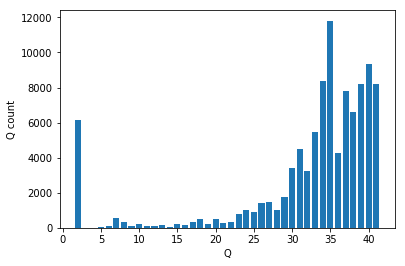

In [16]:
# Use matplotlib to show the a histogram of Qs
import math
rr, qq = readFastq('phix174/SRR835775_1.first1000.fastq')
#%time rr, qq = readFastq('sintetico/sample_01.fasta.fastq')
q = ''.join(qq)
quals = {}
i = 0
TOP = 10000000
#math.pow(10,-(ord('@')-33)/10)
for e in q:
    m = ord(e) - 33
    if m in quals:
        quals[m] += 1
    else:
        quals[m] = 0
    i += 1
    if i > TOP: break

plt.bar(list(quals.keys()), list(quals.values()))
plt.xlabel('Q')
_ = plt.ylabel('Q count')

## Count bases (spark)

In [17]:
# Implement a sequence of spark transformations to read a fasta file 
#   and to compute the number of occurrences of each base. 
# 
# You can use count countBases inside a tranformation instead of a 
# lambda

def count_bases_spark_from_fasta(file, baselist=['A', 'C', 'G', 'T']):
    """ Counts the number of occurrences of each base in a fasta file.
        There are two return values: the list of bases and the list of counts
    """
    fasta_lines = sc.textFile(file)
    data_lines = fasta_lines.filter(lambda line: line[0] != ">")
    bases = data_lines.flatMap(lambda line: list(line))
    base_duples = bases.map(lambda base: (base, 1))
    base_counts = base_duples.reduceByKey(lambda v1, v2 : v1 + v2)
    # Format response
    bases = []
    counts = []
    for (base, count) in base_counts.collect():
        if base in baselist:
            bases.append(base)
            counts.append(count)
    for base in baselist:
        if base not in bases:
            bases.append(base)
            counts.append(0)
    return bases, counts

count_bases_spark_from_fasta("wide.fasta")

(['A', 'C', 'G', 'T'], [0, 0, 0, 0])

### Tests
Files for test:

In [18]:
%%writefile p1.fasta
>NC_000907.1
ATGAAAACATTATTCACTTCGGTTGTATTGTGTGGTGCGCTGGTTGTTTCTTCGTCTTTTGCTGAGGAAA
AAGCGACAGANCAAACCGCTCAATCTGTTGTGACAACTCAAGCTGAAGCTCAAGTAGCACCAGCCGTAGT
GAGCGATAAATTGAATATCAACACAGCAACTGCCAGTGAAATTCAAAAATCCTTAACTGGCATTGGTGCG
AAAAAAGCGGAAGCTATTGTGCAATATCGTGAAAAACACGGTAATTTTKCTAATGCAGAACAGCTTTTAG
AAGTACAAGGAATTGGCAAAGCAACACTAGAGAAAAATCGTGATCGTATAATCTTTTAACCCCC
>NC_000907.2
AAA

Overwriting p1.fasta


In [19]:
%%writefile p2.fasta
>NC_000907.1
ATCG

Overwriting p2.fasta


In [20]:
%%writefile wide.fasta
>NC_000907.1

Overwriting wide.fasta


In [21]:
def test(file, base_list=['A', 'C', 'G', 'T']):
    """
    Verification versus result of count bases not spark
    """
    bases_spark, counts_spark = count_bases_spark_from_fasta(file, base_list)
    print(bases_spark, counts_spark)

    #Calc no spark
    seqs = readFasta(file)
    sequence = "".join(list(seqs.values()))
    bases_no_spark, counts_no_spark = countBases(sequence, base_list)
    print(bases_no_spark, counts_no_spark)

    #Verification
    compares = {}
    for (i, base) in enumerate(bases_spark):
        compares[base] = counts_spark[i]

    for (i, base) in enumerate(bases_no_spark):
        assert compares[base] == counts_no_spark[i]
    print("Test passed for file " + file)
    print()
    
test("p2.fasta")
test("p1.fasta")
test("wide.fasta")

['C', 'A', 'T', 'G'] [1, 1, 1, 1]
['A', 'C', 'G', 'T'] [1, 1, 1, 1]
Test passed for file p2.fasta

['C', 'A', 'T', 'G'] [66, 118, 89, 72]
['A', 'C', 'G', 'T'] [118, 66, 72, 89]
Test passed for file p1.fasta

['A', 'C', 'G', 'T'] [0, 0, 0, 0]
['A', 'C', 'G', 'T'] [0, 0, 0, 0]
Test passed for file wide.fasta



## Compute inverse complementary(spark)

In [22]:
def complementary(gen):
    """ From a sequence of nucleotides return the inverse complementary
          e.g. GAACCT should return AGGTTC
          Hint: Use a dictionary for the translations
        Args:
            gen (str): nucleotide sequence
        
        Returns:
            str: inverse complementary of input sequence
        """
    traslation = { 'A' : 'T', 'C' : 'G', 'T' : 'A', 'G' : 'C',
                   'R' : 'Y',  'Y' : 'R',
                   'S' : 'S',
                   'W' : 'W',
                   'K' : 'M', 'M' : 'K',
                   'B' : 'V', 'V' : 'B',
                   'D' : 'H',  'H' : 'D',
                   'N' : 'N', 'X' : 'X'}
                  
    bases = sc.parallelize(gen)
    bases_complementary = bases.map(lambda base: traslation[base])
    bases_complementary_reverse_join = bases_complementary.reduce(lambda v1,v2 : v2 + v1)
    return bases_complementary_reverse_join

### Tests

In [23]:
# Tests
assert(complementary('G')=='C')
assert(complementary('AT')=='AT')
assert(complementary('GC')=='GC')
assert(complementary('GATACA')=='TGTATC')
# If you added all possible combination of bases uncomment the 
# following line to check
assert(complementary('GATACASWKMYRHDVBN')=='NVBHDYRKMWSTGTATC')

print('All tests OK!')

All tests OK!


## Reading CDS from GFF (spark)

In [24]:
def extractProteinId(attribs):
    """ Extract the protein_id from the complete string of the attributes 
        field of the gff """
    protein_id = attribs[attribs.find("protein_id=")+len("protein_id="):]
    i = protein_id.find(";")
    if i>=0:
        protein_id = protein_id[:i]
        
    return protein_id
    
def extractCDSFromGFF(gff_file):
    """ This function extract the regions information from a gff file for all CDSs.
        
        This function returns a dictionary with the protein_id being the keys and 
        the values in a list with the sequence_id and tuples with (start, end, strand, frame)
        
        Note that a CDS might spread over multiple lines. For each line you should include 
        one tuple.
        
        Check the tests in the next cell for reference        
    """
    cds_regions = {}
    gff_cds_regions = sc.textFile(gff_file).\
        filter(lambda line: len(line) > 0 and line[0] != '#').\
        map(lambda line: line.split("\t")).\
        filter(lambda line: line[2] == 'CDS').\
        map(lambda line: [extractProteinId(line[8]), line[0],\
                          (int(line[3]), int(line[4]), line[6], int(line[7]))])
    # reformat the list as dict 
    for region in gff_cds_regions.collect():
        if region[0] in cds_regions:
            cds_regions[region[0]].append(region[2])
        else:
            cds_regions[region[0]] = [region[1], region[2]]
    return (cds_regions)

### Tests
This is a file for tests

In [25]:
%%writefile test.gff
##gff-version 3
#!gff-spec-version 1.21
#!processor NCBI annotwriter
#!genome-build ASM2730v1
#!genome-build-accession NCBI_Assembly:GCF_000027305.1
##sequence-region NC_000907.1 1 1830138
##species https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=71421
NC_000907.1	RefSeq	region	1	1830138	.	+	.	ID=id0;Dbxref=taxon:71421;Is_circular=true;Name=ANONYMOUS;gbkey=Src;genome=chromosome;mol_type=genomic DNA;old-name=Haemophilus influenzae Rd
NC_000907.1	RefSeq	remark	1	1830138	.	+	.	ID=id1;Note=REFSEQ gene predictions performed by GeneMark 2.4/GeneMark.hmm 2.0 with comparison to original submitter provided annotation%3B tRNA sequences predicted using tRNAscan-SE 1.21;gbkey=Comment
NC_000907.1	RefSeq	gene	2	1021	.	+	.	ID=gene0;Dbxref=GeneID:950899;Name=gapdH;gbkey=Gene;gene=gapdH;gene_biotype=protein_coding;locus_tag=HI0001
NC_000907.1	RefSeq	CDS	2	1021	.	+	0	ID=cds0;Parent=gene0;Dbxref=Genbank:NP_438174.1,GeneID:950899;Name=NP_438174.1;Note=catalyzes the formation of 3-phospho-D-glyceroyl phosphate from D-glyceraldehyde 3-phosphate;gbkey=CDS;gene=gapdH;product=glyceraldehyde-3-phosphate dehydrogenase;protein_id=NP_438174.1;transl_table=11
NC_000907.1	RefSeq	gene	104277	105274	.	+	.	ID=gene101;Dbxref=GeneID:950998;Name=hitA;gbkey=Gene;gene=hitA;gene_biotype=protein_coding;locus_tag=HI0097
NC_000907.1	RefSeq	CDS	104277	104318	.	+	0	ID=cds94;Parent=gene101;Dbxref=Genbank:NP_438271.2,GeneID:950998;Name=NP_438271.2;Note=periplasmic ferric iron binding protein%3B contains a frameshift with respect to purified protein%3B similar to PID:2340838;gbkey=CDS;gene=hitA;product=iron-utilization periplasmic protein hFbpA;protein_id=NP_438271.2;transl_table=11
NC_000907.1	RefSeq	CDS	104318	105274	.	+	0	ID=cds94;Parent=gene101;Dbxref=Genbank:NP_438271.2,GeneID:950998;Name=NP_438271.2;Note=periplasmic ferric iron binding protein%3B contains a frameshift with respect to purified protein%3B similar to PID:2340838;gbkey=CDS;gene=hitA;product=iron-utilization periplasmic protein hFbpA;protein_id=NP_438271.2;transl_table=11

NC_000907.1	RefSeq	CDS	1044343	11	.	+	0	ID=cds94;Parent=gene101;Dbxref=Genbank:NP_438271.2,GeneID:950998;Name=NP_438271.2;Note=periplasmic ferric iron binding protein%3B contains a frameshift with respect to purified protein%3B similar to PID:2340838;gbkey=CDS;gene=hitA;product=iron-utilization periplasmic protein hFbpA;protein_id=NP_438271.2;transl_table=11
###




Overwriting test.gff


In [26]:
display(extractCDSFromGFF('test.gff'))

# Tests
assert(extractCDSFromGFF('haemophilus_influenzae/test1.gff')=={'NP_438174.1': ['NC_000907.1', (2, 1021, '+', 0)]})
assert(extractCDSFromGFF('haemophilus_influenzae/test2.gff')== {'NP_438174.1': ['NC_000907.1',  (2, 1021, '+', 0)],
                                                  'NP_438175.1': ['NC_000907.1',  (1190, 3013, '+', 0)],
                                                  'NP_438176.1': ['NC_000907.1', (3050, 3838, '-', 0)]})
assert(extractCDSFromGFF('haemophilus_influenzae/test3.gff')=={'NP_438174.1': ['NC_000907.1', (2, 1021, '+', 0)],
                 'NP_438271.2': ['NC_000907.1', (104277, 104318, '+', 0), (104318, 105274, '+',  0)]})
print('All test are OK!')

{'NP_438174.1': ['NC_000907.1', (2, 1021, '+', 0)],
 'NP_438271.2': ['NC_000907.1',
  (104277, 104318, '+', 0),
  (104318, 105274, '+', 0),
  (1044343, 11, '+', 0)]}

All test are OK!


## Obtain translation table from cds and protein

In [27]:
def obtainTranslationTable(cds, protein):
    """ Creates a translation dictionary from the protein and DNA sequence.
        The function returns:
            1- A dictionary with the translation table where the codons are the
               keys of the dictionary and the amino acids the values.
            2- The start codon as a string
            
        Note 1: The sequence cds includes start and end codons. 
        Note 2: First codon always codifies M that is also included in the protein.
        Note 3: End codon do not codify an a aminoacid and should be included in the
                dictionary as *.
                
        Example: (Spaces added in seqeunces for readability) 
          cds     = GTG TTT TTG GTG TGG TGA
          protein = M   F   L   V   W
          
          should return
            tranlation dictionary = {'TTT':'F', 'TTG':'L', 'GTG':'V', 'TGG':'W', 'TGA':'*'}
            start codon = 'GTG'
        """
    trans_table = {}
    start_codon = ""
    for i in range(0, len(cds), 3):
        codon = cds[i:i+3]
        if i == 0:
            start_codon = codon
        if len(codon) == 3:
            i_protein = i // 3
            if i_protein >= len(protein):
                trans_table[codon] = '*'
            else:
                trans_table[codon] = protein[i_protein]
    
    return trans_table, start_codon

### Tests

In [28]:
translation_dictionary, start_codon = obtainTranslationTable('GTGTTTTTGGTGTGGTGA','MFLVW')
assert(translation_dictionary=={'TTT':'F', 'TTG':'L', 'GTG':'V', 'TGG':'W', 'TGA':'*'})
assert(start_codon == 'GTG')

print('All test OK!')

All test OK!


## Compose mRNA

In [29]:
def compose_mRNA(cromosome, cds):
    """Returns the mRNA from the complete sequence of DNA and the locations of the CDS. 
        Parameters:
            -cromosome: a string with the whole cromosome
            -cds: a list containing tuples of (start, end, strand, phase) """
    mrna = ''
    #print(cds)
    for (start, end, strand, phase) in cds:
        if strand == '+':
            mrna += cromosome[start + phase - 1: end]
        else:
            mrna += complementary(cromosome[start - 1: end - phase])
        
    return mrna


### Tests

In [30]:
cod = 'GTGTTTTTGGTGTGGTGA'

assert(compose_mRNA(cod,[(1,len(cod),'+',0)])==cod)
assert(compose_mRNA(cod,[(1,len(cod),'-',0)])==complementary(cod))
assert(compose_mRNA("GGGGGGGGGG"+cod+"GGGGGG",[(11,10+len(cod),'+',0)])==cod)
assert(compose_mRNA("GGGGGGGGGG"+cod+"GGGGGG",[(11,10+len(cod),'-',0)])==complementary(cod))
assert(compose_mRNA("GGGGGGGGGG"+cod[:9]+"GGGGGG"+cod[9:],[(11,19,'+',0),(26,34,'+',0)])==cod)
assert(compose_mRNA("GGGGGGGGGG"+cod[:9]+"GGGGGG"+cod[9:],[(26,34,'-',0),(11,19,'-',0)])==complementary(cod))

print("All tests are OK!")

All tests are OK!


## Compute the translation tables

In [31]:
def cleanTransTable(tt):
    # Remove entries that codify 'X' (unknown)
    tt = {k:tt[k] for k in tt if tt[k]!='X'}
    # Remove entries that are not GCAT only
    tt = {k:tt[k] for k in tt if k.count('G')+k.count('C')+k.count('A')+k.count('T') == 3}
    
    return tt

# Read data
genome   = readFasta('haemophilus_influenzae/GCF_000027305.1_ASM2730v1_genomic.fna')
cdss     = extractCDSFromGFF('haemophilus_influenzae/test4.gff')
proteins = readFasta('haemophilus_influenzae/GCF_000027305.1_ASM2730v1_protein.faa')
# Init trans table and start codons
translation_table = {}
start_codons = set()

# Loop over all mRNA found
for protein_id in cdss:
    cds    = cdss[protein_id]
    seq_id = cds[0]
    
    mRNA   = compose_mRNA(genome[seq_id], cds[1:])
    #print(mRNA)
    tt, start_codon = obtainTranslationTable(mRNA, proteins[protein_id])
    
    translation_table.update(tt)
    start_codons.add(start_codon)

# Remove spurious entries from the result
translation_table = cleanTransTable(translation_table)

#Print result
print("List of start codons: ", start_codons)
print("There are {0} entries in the tranlation table.".format(len(translation_table)))
print("Entries:")

for i,k in enumerate(sorted(translation_table.keys())):
    if i%8==0:
        print()
    print(k + "->" + translation_table[k], end='    ')
    


List of start codons:  {'ATG', 'TTG'}
There are 64 entries in the tranlation table.
Entries:

AAA->K    AAC->N    AAG->K    AAT->N    ACA->T    ACC->T    ACG->T    ACT->T    
AGA->R    AGC->S    AGG->R    AGT->S    ATA->I    ATC->I    ATG->M    ATT->I    
CAA->Q    CAC->H    CAG->Q    CAT->H    CCA->P    CCC->P    CCG->P    CCT->P    
CGA->R    CGC->R    CGG->R    CGT->R    CTA->L    CTC->L    CTG->L    CTT->L    
GAA->E    GAC->D    GAG->E    GAT->D    GCA->A    GCC->A    GCG->A    GCT->A    
GGA->G    GGC->G    GGG->G    GGT->G    GTA->V    GTC->V    GTG->V    GTT->V    
TAA->*    TAC->Y    TAG->*    TAT->Y    TCA->S    TCC->S    TCG->S    TCT->S    
TGA->*    TGC->C    TGG->W    TGT->C    TTA->L    TTC->F    TTG->L    TTT->F    

### Test against Biopython

In [32]:
from Bio.Data import CodonTable
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
biopython_table = standard_table.forward_table.copy()
# Add stop codons
for codon in standard_table.stop_codons:
    biopython_table[codon] = "*"
assert biopython_table == translation_table
print("Biopython Verification OK")

Biopython Verification OK


# Exports

In [1]:
# Exports
!jupyter nbconvert --to latex --template ~/report.tplx PRMDM_assignment2.ipynb 1> /dev/null
!pdflatex -shell-escape PRMDM_assignment2.tex 1> /dev/null
!jupyter nbconvert --to html_with_toclenvs PRMDM_assignment2.ipynb 1> /dev/null

[NbConvertApp] Converting notebook PRMDM_assignment2.ipynb to latex
[NbConvertApp] Support files will be in PRMDM_assignment2_files/
[NbConvertApp] Making directory PRMDM_assignment2_files
[NbConvertApp] Making directory PRMDM_assignment2_files
[NbConvertApp] Making directory PRMDM_assignment2_files
[NbConvertApp] Writing 54912 bytes to PRMDM_assignment2.tex
[NbConvertApp] Converting notebook PRMDM_assignment2.ipynb to html_with_toclenvs
[NbConvertApp] Writing 404126 bytes to PRMDM_assignment2.html
